<a href="https://colab.research.google.com/github/ykitaguchi77/statistics_for_articles/blob/main/Canalicular_excision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
import pandas as pd
import codecs
from scipy import stats
import numpy as np

import numpy as np
import scipy
import matplotlib.pyplot as plt
import statistics as stat

import seaborn as sns; sns.set() # sns.set() ==> グラフの見た目をseabornに合わせる
%matplotlib inline

import math

In [ ]:
csv_path = "/content/drive/MyDrive/作成中の論文/涙小管切断/涙小管切除症例1.2.csv"

#Open csv
#with codecs.open(csv_path, "r", "Shift-JIS", "ignore") as file:
with codecs.open(csv_path, "r", "UTF-8", "ignore") as file:
        df = pd.read_csv(file, index_col=None, header=0)
df

#**フォロー期間12ヶ月以上を抜き出し**

In [ ]:
df_long = df[df['Observation period (month)'] >= 12]
len(df_long)
#df_long.columns
pd.set_option('display.max_columns', 100)

df_long = df_long.reset_index()


#手動でone-hotにする
df_long = df_long.replace({"Recurrence": {"None": 0, "Upper": 1, "Lower": 1}})

"""
#これでもいける筈だがうまくいかない
df_long.loc[df_long['Recurrence'] == "None", 'Recurrence'] = 0
df_long.loc[df['Recurrence'] != "None", 'Recurrence'] = 1
"""

df_long


In [ ]:
"""
#上下涙点にNoneが含まれている（＝片方の涙点のみ閉鎖）ものとそうでないもの（＝上下涙点を閉鎖）に分類
df_single= df_long.query("Punctum_upper =='None' or Punctum_lower =='None' ")
df_single

df_double = df_long.query("Punctum_upper !='None' and Punctum_lower !='None' ")
df_double
"""

#手術していない涙小管（上or下）が開いている症例、あるいは経過中に開いた症例をsingleに分類
df_single = df_long.query("Both_punctum == 0")
df_double = df_long.query("Both_punctum == 1")


A = np.array(df_single["TM_pre_mm"])
B = np.array(df_double["TM_pre_mm"])
C = np.array(df_single["TM_3M_mm"])
D = np.array(df_double["TM_3M_mm"])
E = np.array(df_single["Fluo_D_pre"])
F = np.array(df_double["Fluo_D_pre"])
G = np.array(df_single["Fluo_D_post"])
H = np.array(df_double["Fluo_D_post"])


#Welch' t-test (不等分散のt検定)
print(stats.ttest_ind(A, B, equal_var=False))
print(stats.ttest_ind(C, D, equal_var=False))
print(stats.ttest_ind(E, F, equal_var=False))
print(stats.ttest_ind(G, H, equal_var=False))


print()
print(df_single["TM_pre_mm"].describe())
print(df_double["TM_pre_mm"].describe())
print()
print(df_single["TM_3M_mm"].describe())
print(df_double["TM_3M_mm"].describe())
print()
print()
print(df_single["Fluo_D_pre"].describe())
print(df_double["Fluo_D_pre"].describe())
print()
print(df_single["Fluo_D_post"].describe())
print(df_double["Fluo_D_post"].describe())
print()
print("single pre", df_single["Fluo_5area_pre"].describe())
print("double pre", df_double["Fluo_5area_pre"].describe())
print()
print("single 3M", df_single["Fluo_5area_3M"].describe())
print("double 3M", df_double["Fluo_5area_3M"].describe())
print()
print("single 12M", df_single["Fluo_5area_12M"].describe())
print("double 12M", df_double["Fluo_5area_12M"].describe())

In [ ]:
from sklearn.preprocessing import OneHotEncoder

#解析のため文字列を数値に変える
#症例数が少なければ、csvの列を作り直した方が早い

#男性をゼロ、女性を1に
df_long_1 = df_long.replace({"M/F": {"M": 0, "F": 1}})

df_long_1["Sjogren"] = 0
df_long_1["GVHD"] = 0

#pd.get_dummiesを用いてone-hot encodingを行う
df_long_1 = pd.get_dummies(df_long, columns=["M/F"])
df_long_2 = pd.get_dummies(df_long, columns=["Background disease"])
df_long_2

#Scikit learnからone hot encoderを用いる手法
encoder = OneHotEncoder(sparse=False)

arr = encoder.fit_transform(df_long["M/F"].values.reshape(-1, 1))
df_MF = pd.DataFrame(arr)
df_MF.columns = encoder.get_feature_names_out(["gender"])
df_MF

arr = encoder.fit_transform(df_long["Background disease"].values.reshape(-1, 1))
df_BD = pd.DataFrame(arr)
df_BD.columns = encoder.get_feature_names_out(["Background"])
df_BD



In [ ]:
df_long.columns

In [7]:
print(df_long.describe()["TM_pre_mm"])
print("")
print(df_long.describe()["TM_3M_mm"])
print("")
print(df_long.describe()["TM_12M_mm"])
print("")

count    24.000000
mean      0.141763
std       0.042739
min       0.063158
25%       0.123308
50%       0.134831
75%       0.162431
max       0.240000
Name: TM_pre_mm, dtype: float64

count    24.000000
mean      0.304698
std       0.159761
min       0.123077
25%       0.211943
50%       0.293426
75%       0.337500
max       0.789474
Name: TM_3M_mm, dtype: float64

count    24.000000
mean      0.252193
std       0.112405
min       0.090000
25%       0.157895
50%       0.214759
75%       0.339560
max       0.428571
Name: TM_12M_mm, dtype: float64



#TMの変化について検討（ヒストグラム、Wilcoxon)

In [ ]:
#TMの変化についてヒストグラムを描く
A = np.array(df_long["TM_pre_mm"])
B = np.array(df_long["TM_3M_mm"])
C = np.array(df_long["TM_12M_mm"])

#ヒストグラムを記載
fig, ax = plt.subplots(figsize=(8,6), dpi=300)
sns.distplot(
    A, bins=5, color="red", label="pre", kde=False
)
sns.distplot(
    B, bins=20, color="blue", label="post 3M", kde=False
)
sns.set(font_scale = 2)
plt.xlim(0, 0.8)
plt.ylim(0, 10)
plt.show()

fig, ax = plt.subplots(figsize=(8,6), dpi=300)
sns.distplot(
    B, bins=20, color="blue", label="post 3M", kde=False
)
sns.set(font_scale = 2)
plt.xlim(0, 0.8)
plt.ylim(0, 10)
plt.show()

fig, ax = plt.subplots(figsize=(8,6), dpi=300)
sns.distplot(
    C, bins=10, color="green", label="post 3M", kde=False
)
sns.set(font_scale = 2)
plt.xlim(0, 0.8)
plt.ylim(0, 10)
plt.show()

In [ ]:
#TMの変化について検討
A = np.array(df_long["TM_pre_mm"])
B = np.array(df_long["TM_3M_mm"])
C = np.array(df_long["TM_12M_mm"])

#等分散検定（どちらかで<0.05ならt検定は使わない方が無難）
print(scipy.stats.bartlett(A,B))
print(scipy.stats.levene(A,B))

#等分散の確認 その2
A_var = np.var(A, ddof=1)  # Aの不偏分散
B_var = np.var(B, ddof=1)  # Bの不偏分散
A_df = len(A) - 1  # Aの自由度
B_df = len(B) - 1  # Bの自由度
f = A_var / B_var  # F比の値
one_sided_pval1 = stats.f.cdf(f, A_df, B_df)  # 片側検定のp値 1
one_sided_pval2 = stats.f.sf(f, A_df, B_df)   # 片側検定のp値 2
two_sided_pval = min(one_sided_pval1, one_sided_pval2) * 2  # 両側検定のp値
print('F:       ', round(f, 3))
print('p-value: ', round(two_sided_pval, 3)) #p<0.05なら分散が等しくないと言える

#等分散の確認 その3
varA = stats.tvar(A)
varB = stats.tvar(B)
dfn = len(B) -1
dfd = len(A) -1
f = varB/varA #分子に大きい方を置く
print("f_value: ", f)
p = stats.f.cdf(f, dfn=dfn, dfd=dfd)
print("p-value: ", p) #p>0.05なら分散が等しくないと言える

#正規性の検定（分散が等しい場合に使える）
#p<0.05の場合だと正規分布ではないのでt検定は使えない
print(stats.shapiro(A))
print(stats.shapiro(B))

#等分散かつ正規分布ならstudent-t
print(stats.ttest_rel(A, B))

#Wilcoxon
print(stats.wilcoxon(A, B,  correction=True))
print(stats.wilcoxon(B, C,  correction=True))

In [21]:
#Fluorecence scoreの変化について検討
#TMの変化について検討
A = np.array(df_long["Fluo_5area_pre"])
B = np.array(df_long["Fluo_5area_3M"])
C = np.array(df_long["Fluo_5area_12M"])

#等分散検定（どちらかで<0.05ならt検定は使わない方が無難）
print(scipy.stats.bartlett(A,B))
print(scipy.stats.levene(A,B))

#等分散の確認 その2
A_var = np.var(A, ddof=1)  # Aの不偏分散
B_var = np.var(B, ddof=1)  # Bの不偏分散
A_df = len(A) - 1  # Aの自由度
B_df = len(B) - 1  # Bの自由度
f = A_var / B_var  # F比の値
one_sided_pval1 = stats.f.cdf(f, A_df, B_df)  # 片側検定のp値 1
one_sided_pval2 = stats.f.sf(f, A_df, B_df)   # 片側検定のp値 2
two_sided_pval = min(one_sided_pval1, one_sided_pval2) * 2  # 両側検定のp値
print('F:       ', round(f, 3))
print('p-value: ', round(two_sided_pval, 3)) #p<0.05なら分散が等しくないと言える

#等分散の確認 その3
varA = stats.tvar(A)
varB = stats.tvar(B)
dfn = len(B) -1
dfd = len(A) -1
f = varB/varA #分子に大きい方を置く
print("f_value: ", f)
p = stats.f.cdf(f, dfn=dfn, dfd=dfd)
print("p-value: ", p) #p>0.05なら分散が等しくないと言える

#正規性の検定（分散が等しい場合に使える）
#p<0.05の場合だと正規分布ではないのでt検定は使えない
print(stats.shapiro(A))
print(stats.shapiro(B))



#等分散かつ正規分布ならstudent-t
print(stats.ttest_rel(A, B))

#Wilcoxon
print(stats.wilcoxon(A, B,  correction=False))
print(stats.wilcoxon(B, C,  correction=False))
print(stats.wilcoxon(A, C,  correction=False))
print(stats.friedmanchisquare(A, B, C))

#対応のあるノンパラメトリック多重比較
#https://www.noguchilabo.com/spss-nonpara-posthooktest/


BartlettResult(statistic=0.4148779116864953, pvalue=0.5195039957070385)
LeveneResult(statistic=0.6725690579783462, pvalue=0.4163867736683038)
F:        1.312
p-value:  0.52
f_value:  0.761904761904762
p-value:  0.25977204455122466
(0.9728745818138123, 0.7379323244094849)
(0.8759365677833557, 0.006890854798257351)
Ttest_relResult(statistic=6.377833668089035, pvalue=1.6534998948921872e-06)
WilcoxonResult(statistic=7.0, pvalue=4.315782395361889e-05)
WilcoxonResult(statistic=81.5, pvalue=0.3774734943092596)
WilcoxonResult(statistic=30.5, pvalue=0.0010463188643803924)
FriedmanchisquareResult(statistic=16.76923076923075, pvalue=0.00022835356998738651)


#箱ひげ図

In [43]:
#フルオレセインスコア
#データ整形
from numpy.lib.function_base import kaiser
df_fluo_pre = pd.DataFrame(columns=["score", "status"])
df_fluo_3M = pd.DataFrame(columns=["score", "status"])
df_fluo_12M = pd.DataFrame(columns=["score", "status"])


for i in range(len(df_long)):
    df_fluo_pre.loc[i, "score"] = df_long.loc[i, "Fluo_5area_pre"]
    df_fluo_pre.loc[i, "status"] = "pre"

for i in range(len(df_long)):
    df_fluo_3M.loc[i, "score"] = df_long.loc[i, "Fluo_5area_3M"]
    df_fluo_3M.loc[i, "status"] = "post_3M"

for i in range(len(df_long)):
    df_fluo_12M.loc[i, "score"] = df_long.loc[i, "Fluo_5area_12M"]
    df_fluo_12M.loc[i, "status"] = "post_12M"

df_fluo = pd.concat([df_fluo_pre, df_fluo_3M, df_fluo_12M], axis=0)
df_fluo

,score,status
0,13.0,pre
1,10.0,pre
2,12.0,pre
3,1.0,pre
4,3.0,pre
...,...,...
19,3.0,post_12M
20,5.0,post_12M
21,11.0,post_12M
22,3.0,post_12M


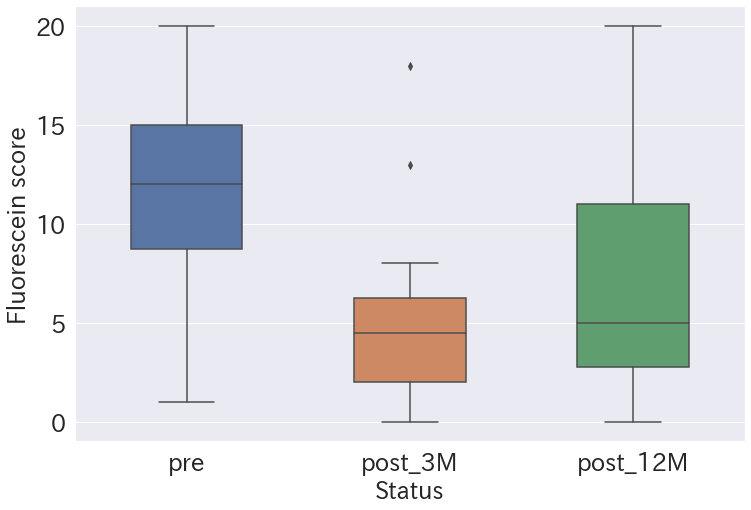

In [68]:
#箱ひげ図
#https://dataanablog.com/python-beginner-drawing-a-box-and-whisker-diagram-with-matplotlib-and-seaborn-data-visualization/
#!pip install japanize_matplotlib
import japanize_matplotlib       # グラフに日本語が使える

plt.figure(figsize=(12,8))

sns.boxplot(x=df_fluo["status"], y=df_fluo["score"],width=0.5,order=df_fluo.status.unique())

#plt.title("Fluorescein score",fontsize=20)   # タイトルを指定する、文字の大きさを指定
plt.ylabel("Fluorescein score",fontsize=24)         # ｙ軸のラベルを指定、文字の大きさを指定
plt.xlabel("Status",fontsize=24)           # ｘ軸のラベルを指定、文字の大きさを指定
plt.yticks([0, 5, 10, 15, 20])
plt.tick_params(labelsize=24)

plt.show()

In [77]:
#涙液メニスカス
#データ整形
from numpy.lib.function_base import kaiser
df_singles = df_single.reset_index()
df_doubles = df_double.reset_index()

df_single_TM_pre = pd.DataFrame(columns=["punctum", "mm", "status"])
df_single_TM_3M = pd.DataFrame(columns=["punctum", "mm", "status"])
df_single_TM_12M = pd.DataFrame(columns=["punctum", "mm", "status"])
df_double_TM_pre = pd.DataFrame(columns=["punctum", "mm", "status"])
df_double_TM_3M = pd.DataFrame(columns=["punctum", "mm", "status"])
df_double_TM_12M = pd.DataFrame(columns=["punctum", "mm", "status"])

for i in range(len(df_single)):
    df_single_TM_pre.loc[i, "punctum"] = "One side closed"
    df_single_TM_pre.loc[i, "mm"] = df_singles.loc[i, "TM_pre_mm"]
    df_single_TM_pre.loc[i, "status"] = "preOP"

for i in range(len(df_double)):
    df_double_TM_pre.loc[i, "punctum"] = "Both side closed"
    df_double_TM_pre.loc[i, "mm"] = df_doubles.loc[i, "TM_pre_mm"]
    df_double_TM_pre.loc[i, "status"] = "preOP"

for i in range(len(df_single)):
    df_single_TM_3M.loc[i, "punctum"] = "One side closed"
    df_single_TM_3M.loc[i, "mm"] = df_singles.loc[i, "TM_3M_mm"]
    df_single_TM_3M.loc[i, "status"] = "postOP_3M"

for i in range(len(df_double)):
    df_double_TM_3M.loc[i, "punctum"] = "Both side closed"
    df_double_TM_3M.loc[i, "mm"] = df_doubles.loc[i, "TM_3M_mm"]
    df_double_TM_3M.loc[i, "status"] = "postOP_3M"

for i in range(len(df_single)):
    df_single_TM_12M.loc[i, "punctum"] = "One side closed"
    df_single_TM_12M.loc[i, "mm"] = df_singles.loc[i, "TM_12M_mm"]
    df_single_TM_12M.loc[i, "status"] = "postOP_12M"

for i in range(len(df_double)):
    df_double_TM_12M.loc[i, "punctum"] = "Both side closed"
    df_double_TM_12M.loc[i, "mm"] = df_doubles.loc[i, "TM_12M_mm"]
    df_double_TM_12M.loc[i, "status"] = "postOP_12M"

df_TM = pd.concat([df_single_TM_pre, df_double_TM_pre, df_single_TM_3M, df_double_TM_3M, df_single_TM_12M, df_double_TM_12M], axis=0)
df_TM


,punctum,mm,status
0,One side closed,0.157895,preOP
1,One side closed,0.157895,preOP
2,One side closed,0.126316,preOP
3,One side closed,0.18,preOP
4,One side closed,0.24,preOP
...,...,...,...
12,Both side closed,0.186047,postOP_12M
13,Both side closed,0.342857,postOP_12M
14,Both side closed,0.428571,postOP_12M
15,Both side closed,0.428571,postOP_12M


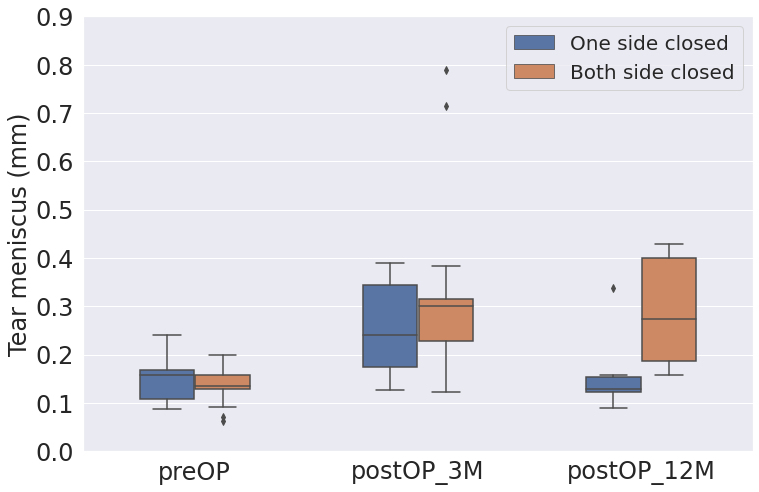

In [81]:
#https://stats.biopapyrus.jp/python/boxplot.html
#横並びのboxplot

plt.figure(figsize=(12,8))

#ボックスプロットを追加
sns.boxplot(x=df_TM["status"], y=df_TM["mm"], data=df_TM, width=0.5,order=df_TM.status.unique(), hue="punctum")
#ドットプロットを追加
#sns.swarmplot(x=df_TM["status"], y=df_TM["mm"],data=df_TM, color="r",order=df_TM.status.unique(), hue="punctum",dodge=True)


plt.title("",fontsize=24)   # タイトルを指定する、文字の大きさを指定
plt.ylabel("Tear meniscus (mm)",fontsize=24)         # ｙ軸のラベルを指定、文字の大きさを指定
plt.xlabel("",fontsize=24)           # ｘ軸のラベルを指定、文字の大きさを指定
plt.yticks([x*0.1 for x in range(10)])
plt.tick_params(labelsize=24)
plt.legend(fontsize = 20)


plt.show()

#データの外観を確認

In [137]:
df_long.value_counts("M/F")

M/F
F    17
M     7
dtype: int64

In [138]:
df_long.describe()["Age (yrs)"]

count    24.000000
mean     58.333333
std      15.159060
min      37.000000
25%      48.000000
50%      53.000000
75%      73.250000
max      86.000000
Name: Age (yrs), dtype: float64

In [ ]:
df_long.value_counts("Side")

Side
R    13
L    11
dtype: int64

In [ ]:
df_long.value_counts("History")

History
Punctal occulusion    5
dtype: int64

In [ ]:
df_long.describe()["Pre Schirmer I"]

count    23.000000
mean      3.130435
std       2.379923
min       0.000000
25%       1.500000
50%       2.000000
75%       3.500000
max       8.000000
Name: Pre Schirmer I, dtype: float64

In [ ]:
df_long.value_counts("History")

History
Punctal occulusion    5
dtype: int64

In [ ]:
print(df_long.describe()["Fluo_D_pre"])
print(df_long.value_counts("Fluo_D_pre"))

count    24.000000
mean      2.583333
std       0.503610
min       2.000000
25%       2.000000
50%       3.000000
75%       3.000000
max       3.000000
Name: Fluo_D_pre, dtype: float64
Fluo_D_pre
3.0    14
2.0    10
dtype: int64


In [ ]:
print(df_long.describe()["Fluo_D_pre"])
print(df_long.value_counts("Fluo_D_pre"))

In [139]:
print(df_long.describe()["Fluo_D_post"])
print(df_long.value_counts("Fluo_D_post"))

count    24.000000
mean      1.375000
std       1.013496
min       0.000000
25%       0.750000
50%       1.500000
75%       2.000000
max       3.000000
Name: Fluo_D_post, dtype: float64
Fluo_D_post
2    9
0    6
1    6
3    3
dtype: int64


In [140]:
print(df_long.describe()["Filamentosa_pre"])
print(df_long.value_counts("Filamentosa_pre"))

count    24.000000
mean      0.208333
std       0.414851
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000
Name: Filamentosa_pre, dtype: float64
Filamentosa_pre
0    19
1     5
dtype: int64


In [141]:
print(df_long.describe()["Filamentosa_post"])
print(df_long.value_counts("Filamentosa_post"))

count    24.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: Filamentosa_post, dtype: float64
Filamentosa_post
0    24
dtype: int64


In [142]:
print(df_long.describe()["Pre Schirmer I"])
print(df_long.value_counts("Pre Schirmer I"))


count    24.000000
mean      3.083333
std       2.339020
min       0.000000
25%       1.750000
50%       2.000000
75%       3.250000
max       8.000000
Name: Pre Schirmer I, dtype: float64
Pre Schirmer I
2.0    7
1.0    5
3.0    5
7.0    4
0.0    1
4.0    1
8.0    1
dtype: int64


In [ ]:
A = np.array(df_long["Pre Schirmer I"])
fig, ax = plt.subplots(figsize=(8,6), dpi=300)
sns.distplot(
    A, bins=8, color="green", label="post 3M", kde=False
)
sns.set(font_scale = 2)
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.show()

In [110]:
print(df_long.describe()["Recurrent period (month)"])


count    4.000000
mean     4.250000
std      2.986079
min      1.000000
25%      2.500000
50%      4.000000
75%      5.750000
max      8.000000
Name: Recurrent period (month), dtype: float64


In [111]:
print(df_long["Recurrence"].value_counts())


None     20
Upper     3
Lower     1
Name: Recurrence, dtype: int64


In [144]:
print(df_long.columns)

Index(['index', 'ID', 'Patient NO', 'name', 'OP date', 'OP date2', 'Age (yrs)',
       'M/F', 'Background disease', 'History', 'Side',
       'Observation period (month)', 'Punctum_upper', 'Punctum_lower',
       'Pre Schirmer I', 'FBUT _pre', 'FBUT_post', 'Fluo_A_pre', 'Fluo_D_pre',
       'Fluo_A_post', 'Fluo_D_post', 'Filamentosa_pre', 'Filamentosa_post',
       'TM_pre_px', 'TM_pre_corneaPX', 'TM_pre_mm', 'TM_3M_px',
       'TM_3M_corneaPX', 'TM_3M_mm', 'TM_12M_px', 'TM_12M_corneaPX',
       'TM_12M_mm', 'Observation period (month).1', 'followup_status',
       'Recurrence', 'Recurrent period (month)', 'Unnamed: 35',
       'Mibum finding', 'Mubum score', 'pre eyedrop', 'post eyedrop', '備考'],
      dtype='object')


In [145]:
#Fluoの変化は有意
stats.wilcoxon(df_long['Fluo_D_pre'], df_long['Fluo_D_post'])

WilcoxonResult(statistic=0.0, pvalue=0.00021982609891843375)

   pre  post
0    0     3
1    0     6
2   10     6
3   14     9


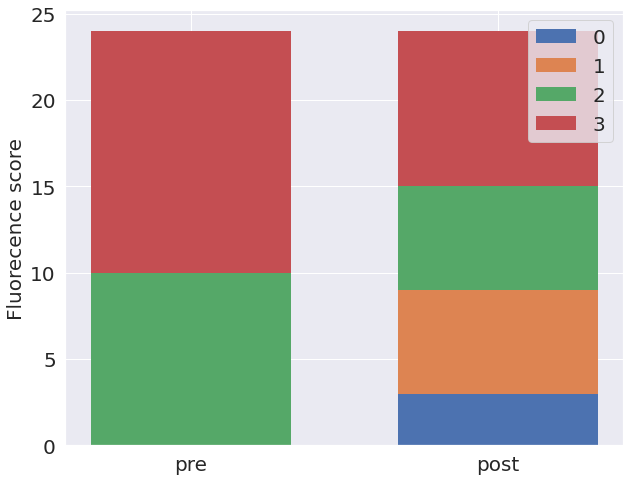

In [146]:
df_fluo = pd.DataFrame(index=["0","1","2","3"], columns = ["pre", "post"])
pre = np.array(df_long['Fluo_D_pre'].value_counts())
pre = np.append(pre, [0,0])
post = np.array(df_long['Fluo_D_post'].value_counts())
df_fluo["pre"] = np.flip(pre)
df_fluo["post"] = np.flip(post)
print(df_fluo)

fig, ax = plt.subplots(figsize=(10, 8))
for i in range(len(df_fluo)):
    ax.bar(df_fluo.columns, 
           df_fluo.iloc[i], linewidth = 0, width=0.65,
           bottom=df_fluo.iloc[:i].sum()
          )
    for j in range(len(df_fluo.columns)):
        """
        plt.text(x=j, 
                 y=df_fluo.iloc[:i, j].sum()+(df_fluo.iloc[i, j]/2), 
                 s=f'{df_fluo.iloc[i, j]}%', 
                 ha='center', 
                 va='bottom'
                )
        """
plt.xlabel("", fontsize=20)
plt.ylabel("Fluorecence score", fontsize=20)
plt.setp(ax.get_xticklabels(), fontsize=20)
plt.setp(ax.get_yticklabels(), fontsize=20)
ax.legend(df_fluo.index, loc='upper right', fontsize=20)
plt.show()



In [115]:
print(df_long.columns)

Index(['index', 'ID', 'Patient NO', 'name', 'OP date', 'OP date2', 'Age (yrs)',
       'M/F', 'Background disease', 'History', 'Side',
       'Observation period (month)', 'Punctum_upper', 'Punctum_lower',
       'Pre Schirmer I', 'FBUT _pre', 'FBUT_post', 'Fluo_A_pre', 'Fluo_D_pre',
       'Fluo_A_post', 'Fluo_D_post', 'Filamentosa_pre', 'Filamentosa_post',
       'TM_pre_px', 'TM_pre_corneaPX', 'TM_pre_mm', 'TM_3M_px',
       'TM_3M_corneaPX', 'TM_3M_mm', 'TM_12M_px', 'TM_12M_corneaPX',
       'TM_12M_mm', 'Observation period (month).1', 'followup_status',
       'Recurrence', 'Recurrent period (month)', 'Unnamed: 35',
       'Mibum finding', 'Mubum score', 'pre eyedrop', 'post eyedrop', '備考'],
      dtype='object')


In [190]:
df_long["Observation period (month)"].describe()

count    24.000000
mean     22.500000
std       8.182696
min      12.000000
25%      14.750000
50%      24.000000
75%      28.250000
max      36.000000
Name: Observation period (month), dtype: float64

In [ ]:
#欠損値の確認
df_long.isnull().sum()

In [54]:
#欠損値を中央値で埋める
df_long['Pre Schirmer I'] = df_long['Pre Schirmer I'].fillna(df_long['Pre Schirmer I'].median())

In [243]:
from sklearn import linear_model

df_long_3 = pd.concat([df_long, df_BD], axis=1)
df_long_3.columns


#X = df_long.loc[:, ["Fluo_D_pre", "Filamentosa_pre", "Pre Schirmer I", "Age (yrs)", "Gender_F", "Backgroud_Sjogren", "Background_GVHD"]].values
#->
X = df_long_3.loc[:, ["Fluo_D_pre", "TM_pre_mm", "Filamentosa_pre", "Pre Schirmer I", "Recurrence"]].values

Y = df_long_3["Fluo_D_post"].values

model = linear_model.LinearRegression()
model.fit(X,Y)
model.coef_

# データフレームに変換し、カラム名とインデックス名を指定
#df_coefficient = pd.DataFrame(model.coef_, columns=["Fluo_D_post"], index=["Fluo_D_pre", "Filamentosa_pre", "Pre Schirmer I", "Age (yrs)", "Gender_F", "Backgroud_Sjogren", "Background_GVHD"])
df_coefficient = pd.DataFrame(model.coef_, columns=["Fluo_D_post"], index=["Fluo_D_pre", "TM_pre_mm", "Filamentosa_pre", "Pre Schirmer I", "Recurrence"])
df_coefficient

,Fluo_D_post
Fluo_D_pre,1.000628
TM_pre_mm,-6.534946
Filamentosa_pre,-0.832839
Pre Schirmer I,-0.046505
Recurrence,-0.129463


In [244]:
import statsmodels.api as sm

model = sm.OLS(Y, sm.add_constant(X))
results = model.fit()
print(results.summary())
# --> 術後SPKの重症度と有意に相関する項目なし


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     1.268
Date:                Wed, 23 Mar 2022   Prob (F-statistic):              0.320
Time:                        14:25:22   Log-Likelihood:                -30.245
No. Observations:                  24   AIC:                             72.49
Df Residuals:                      18   BIC:                             79.56
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0549      1.176      0.047      0.9

In [203]:
A = np.array(df_long["Fluo_D_post"])

In [ ]:
"""
from scipy.stats import pearsonr
A = df_long["Fluo_D_post"]
AA= df_long[["Fluo_D_post"]]
B = df_long["Fluo_D_pre"]
C = df_long["TM_pre_mm"]
D = df_long["Filamentosa_pre"]
E = df_long["Pre Schirmer I"]
F = df_long["TM_3M_mm"]
G = df_long["Recurrence"]

for i, j in zip ([B,C,D,E], ["Fluo_D_pre", "TM_pre_mm", "Filamentosa_pre", "Pre Shirmer I", "TM_3M_mm", "Recurrence"]):
    a, b = pearsonr(A, i)
    print(j)
    print("相関係数:", a)
    print("p値:", b)

    model = linear_model.LinearRegression()
    results = model.fit(AA, i)
    print("coef: ", model.coef_)
    print("")
"""

In [ ]:
import statsmodels.api as sm

for i in ["Fluo_D_pre", "TM_pre_mm", "Filamentosa_pre", "Pre Schirmer I", "TM_3M_mm", "Recurrence"]:
    print(i)
    X = df_long.loc[:, [i]].values
    Y = df_long["Fluo_D_post"].values
    model = sm.OLS(Y, sm.add_constant(X))
    results = model.fit()
    print(results.summary())
    print("")

In [ ]:
import statsmodels.api as sm

#for i in ["Fluo_5area_pre", "Fluo_5area_3M", "TM_pre_mm", "Filamentosa_pre", "Pre Schirmer I", "TM_3M_mm", "Recurrence"]:
for i in ["Fluo_5area_3M", "Pre Schirmer I", "TM_12M_mm"]:

    print(i)
    X = df_long.loc[:, [i]].values
    Y = df_long["Fluo_5area_12M"].values
    model = sm.OLS(Y, sm.add_constant(X))
    results = model.fit()
    print(results.summary())
    print("")

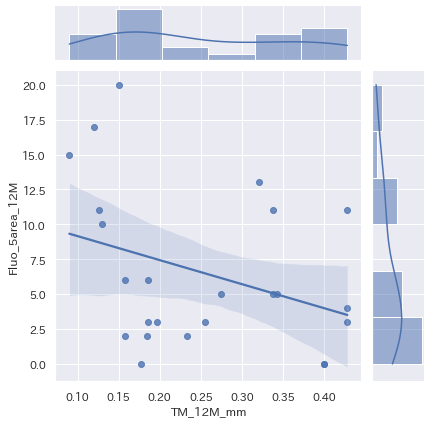

In [60]:

#ヒストグラムつきの散布図を作成
sns.jointplot(x=df_long["TM_12M_mm"], y=df_long["Fluo_5area_12M"], kind='reg')
plt.show()

In [152]:
df_long.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))


,index,ID,Patient NO,OP date,OP date2,Age (yrs),Observation period (month),Pre Schirmer I,FBUT _pre,FBUT_post,Fluo_A_pre,Fluo_D_pre,Fluo_A_post,Fluo_D_post,Filamentosa_pre,Filamentosa_post,TM_pre_px,TM_pre_corneaPX,TM_pre_mm,TM_3M_px,TM_3M_corneaPX,TM_3M_mm,TM_12M_px,TM_12M_corneaPX,TM_12M_mm,Observation period (month).1,Recurrent period (month),Unnamed: 35,Mubum score
count,24,24,24,24,3,24,24,24,7,4,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,4,0,0
mean,16.4167,9.84823e+06,12.375,2.0196e+07,2.01908e+07,58.3333,22.5,3.08333,1.57143,4.5,2.16667,2.58333,1.41667,1.375,0.208333,0,4.41667,378.417,0.141763,9.45833,376.875,0.304698,7.70833,388.333,0.252193,22.5,4.25,nan,nan
std,10.9382,2.15076e+06,8.3396,9939.24,9691.5,15.1591,8.1827,2.33902,0.534522,2.88675,0.701964,0.50361,1.05981,1.0135,0.414851,0,1.66594,41.1835,0.0427392,5.38903,42.0541,0.159761,3.15511,16.3486,0.112405,8.1827,2.98608,nan,nan
min,0,4.54445e+06,1,2.01809e+07,2.01811e+07,37,12,0,1,2,1,2,0,0,0,0,2,259,0.0631579,4,250,0.123077,3,360,0.09,12,1,nan,nan
25%,7.75,8.88924e+06,5.75,2.01906e+07,2.0186e+07,48,14.75,1.75,1,2,2,2,0.75,0.75,0,0,3,373.75,0.123308,6,377.5,0.211943,5,380,0.157895,14.75,2.5,nan,nan
50%,14,1.05975e+07,10,2.01909e+07,2.01908e+07,53,24,2,2,4.5,2,3,1.5,1.5,0,0,4,380,0.134831,8,384.5,0.293426,7.5,389.5,0.214759,24,4,nan,nan
75%,25.25,1.13091e+07,20.25,2.02033e+07,2.01957e+07,73.25,28.25,3.25,2,7,3,3,2,2,0,0,5.25,400,0.162431,11,400,0.3375,10.25,400,0.33956,28.25,5.75,nan,nan
max,36,1.19715e+07,26,2.02104e+07,2.02005e+07,86,36,8,2,7,3,3,3,3,1,0,8,429,0.24,25,420,0.789474,15,420,0.428571,36,8,nan,nan


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f39c77fbf90>,
      dtype=object)

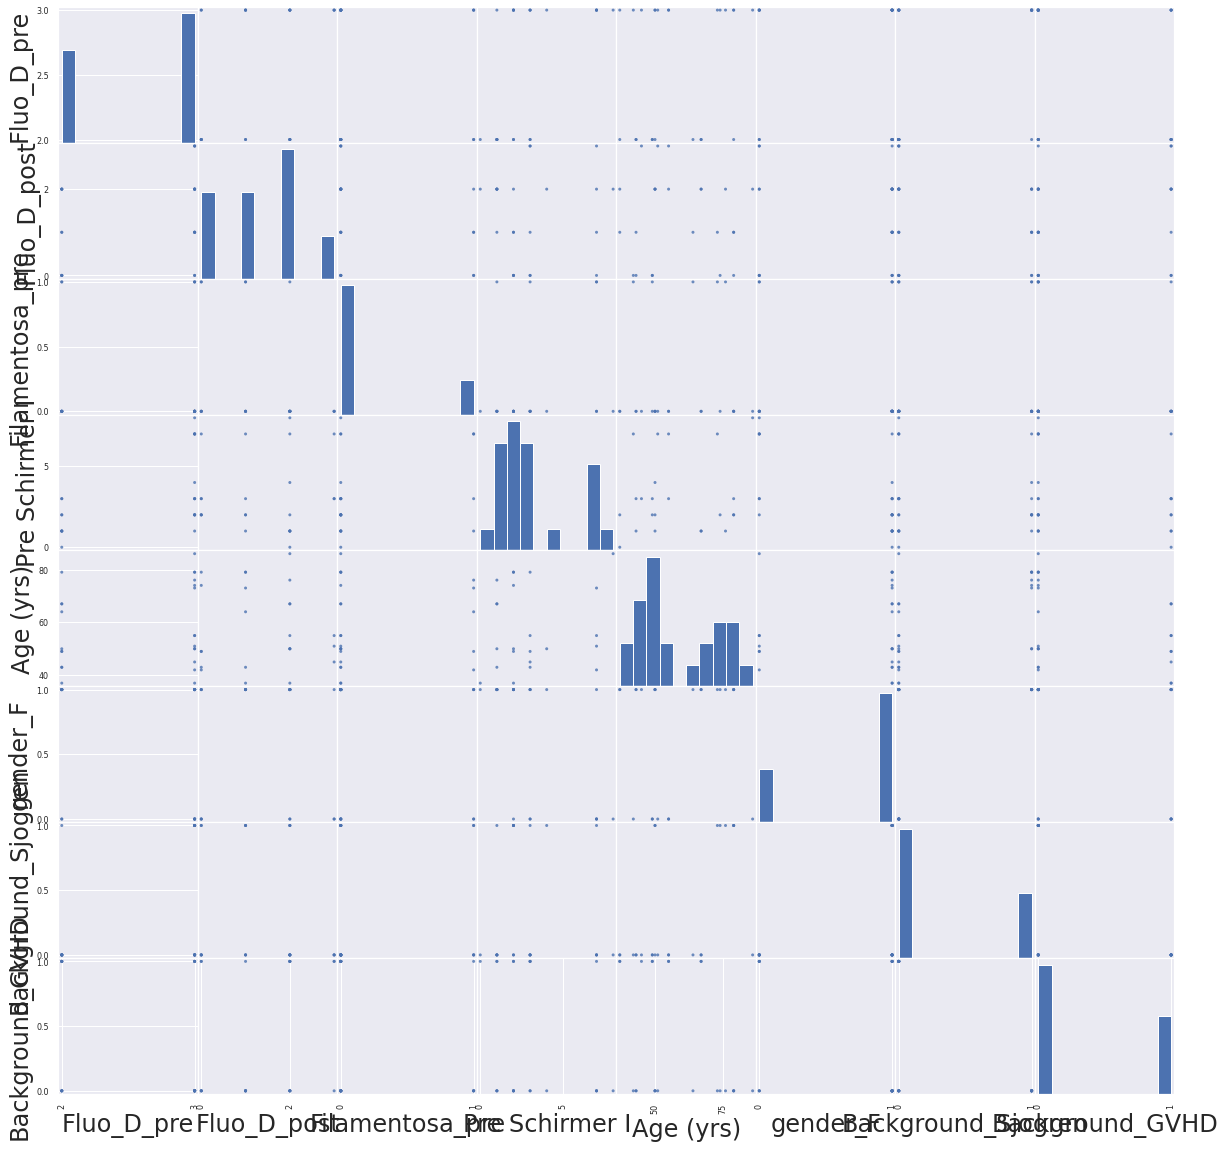

In [167]:
# matplotlibを日本語表示に対応させるモジュール
!pip install japanize_matplotlib
import japanize_matplotlib

# pandasのplottingメソッドをインポート
from pandas import plotting

# 散布図行列を表示

df_long2 = pd.concat([df_long, df_MF, df_BD], axis=1)
df_Z = df_long2[["Fluo_D_pre", "Fluo_D_post", "Filamentosa_pre", "Pre Schirmer I", "Age (yrs)", "gender_F", "Background_Sjogren", "Background_GVHD"]]
plotting.scatter_matrix(df_Z, figsize=(20, 20), alpha=0.8)

In [168]:
df_Z

,Fluo_D_pre,Fluo_D_post,Filamentosa_pre,Pre Schirmer I,Age (yrs),gender_F,Background_Sjogren,Background_GVHD
0,2,1,0,1.0,43,1.0,0.0,0.0
1,2,0,0,3.0,43,1.0,0.0,0.0
2,3,0,0,2.0,74,1.0,1.0,0.0
3,2,2,0,1.0,67,1.0,0.0,1.0
4,2,2,0,1.0,67,1.0,0.0,1.0
5,2,0,0,2.0,79,1.0,1.0,0.0
6,3,1,0,3.0,79,1.0,1.0,0.0
7,3,1,0,2.0,79,1.0,1.0,0.0
8,2,1,1,NaN,64,1.0,0.0,0.0
9,3,2,0,4.0,50,1.0,1.0,0.0


In [169]:
df_Z.corr()
# --> 相関が多少でもありそうなのは、pre-ShirmerとFluo-D-preぐらい

,Fluo_D_pre,Fluo_D_post,Filamentosa_pre,Pre Schirmer I,Age (yrs),gender_F,Background_Sjogren,Background_GVHD
Fluo_D_pre,1.000000,0.319438,0.017342,0.542493,0.201229,-0.170445,0.418330,-0.218218
Fluo_D_post,0.319438,1.000000,-0.297301,0.070737,-0.059429,-0.034648,-0.178174,0.227710
Filamentosa_pre,0.017342,-0.297301,1.000000,0.269976,0.085268,-0.122267,0.072548,-0.185435
Pre Schirmer I,0.542493,0.070737,0.269976,1.000000,0.129473,-0.612467,-0.080144,-0.236301
Age (yrs),0.201229,-0.059429,0.085268,0.129473,1.000000,0.131782,0.555906,-0.371178
gender_F,-0.170445,-0.034648,-0.122267,-0.612467,0.131782,1.000000,0.453743,-0.260360
Background_Sjogren,0.418330,-0.178174,0.072548,-0.080144,0.555906,0.453743,1.000000,-0.547723
Background_GVHD,-0.218218,0.227710,-0.185435,-0.236301,-0.371178,-0.260360,-0.547723,1.000000


Pre_Fluo D2:
       Fluo_D_pre  Pre Schirmer I
count        10.0       10.000000
mean          2.0        1.600000
std           0.0        0.966092
min           2.0        0.000000
25%           2.0        1.000000
50%           2.0        1.500000
75%           2.0        2.000000
max           2.0        3.000000
Pre_Fluo D3:
       Fluo_D_pre  Pre Schirmer I
count        14.0       14.000000
mean          3.0        4.142857
std           0.0        2.476261
min           3.0        1.000000
25%           3.0        2.000000
50%           3.0        3.000000
75%           3.0        7.000000
max           3.0        8.000000
Pre_Fluo D2:
0     1.0
1     3.0
3     1.0
4     1.0
5     2.0
8     2.0
15    0.0
16    1.0
22    3.0
23    2.0
Name: Pre Schirmer I, dtype: float64
Pre_Fluo D3:
2     2.0
6     3.0
7     2.0
9     4.0
10    2.0
11    1.0
12    7.0
13    8.0
14    2.0
17    7.0
18    3.0
19    7.0
20    7.0
21    3.0
Name: Pre Schirmer I, dtype: float64
0.10592225143757877


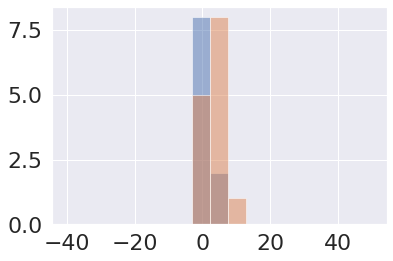

Ttest_indResult(statistic=-3.4885285422154535, pvalue=0.0026309609708969257)

In [162]:
from scipy import stats
import matplotlib.pyplot as plt

df_Kruskal = df_long[["Fluo_D_pre", "Pre Schirmer I"]]
B = df_Kruskal.query("Fluo_D_pre == 2")
C = df_Kruskal.query("Fluo_D_pre == 3")
print("Pre_Fluo D2:")
print(B.describe())
print("Pre_Fluo D3:")
print(C.describe())

y = B["Pre Schirmer I"]
z = C["Pre Schirmer I"]

print("Pre_Fluo D2:")
print(y)
print("Pre_Fluo D3:")
print(z)

# visualize
bins = np.linspace(-40,50,18)
plt.hist(y,bins,alpha=0.5)
plt.hist(z,bins,alpha=0.5)

# hypothesis testing
result = stats.mannwhitneyu(x,y)
print(result.pvalue)

plt.show()

#Welchのt検定
stats.ttest_ind(y,z, equal_var = False)


#--> シルマー値が高いほど、術前の角膜上皮障害が強い、となり実情にそぐわない

In [ ]:
from scipy import stats
df_Kruskal = df_long[["Fluo_D_post", "Pre Schirmer I"]]
A = df_Kruskal.query("Fluo_D_post == 1")
B = df_Kruskal.query("Fluo_D_post == 2")
C = df_Kruskal.query("Fluo_D_post == 3")
print("Post_Fluo D1:")
print(A.describe())
print("Post_Fluo D2:")
print(B.describe())
print("Post_Fluo D3:")
print(C.describe())


x = A["Pre Schirmer I"]
y = B["Pre Schirmer I"]
z = C["Pre Schirmer I"]

print("Post_Fluo D1:")
print(x)
print("Post_Fluo D2:")
print(y)
print("Post_Fluo D3:")
print(z)


stats.kruskal(x, y, z)

#--> シルマー値が低いほど、術前の角膜上皮障害が強い

#**患者別**

In [ ]:
df_long_pts = df_long.drop_duplicates(subset=['Patient NO'], keep="last")
print("Patient number: ", len(df_long_pts))
df_long_pts


In [172]:
df_long_pts["M/F"].value_counts()

NameError: ignored

In [ ]:
df_long_pts.describe()["Age (yrs)"]

count    17.000000
mean     60.000000
std      15.568397
min      37.000000
25%      49.000000
50%      55.000000
75%      74.000000
max      86.000000
Name: Age (yrs), dtype: float64

In [ ]:
print(df_long_pts.value_counts("Background disease"))

Background disease
Sjogren             6
GVHD                5
BSK                 1
Post RT             1
RA+ドライアイ、角膜感染       1
Sjogren, SLE, RA    1
Sjogren未検           1
強皮症                 1
dtype: int64


In [ ]:
"""

M/F
F    13
M     5
dtype: int64


Background disease
Sjogren             6
GVHD                5
BSK                 1
Post RT             1
RA+ドライアイ、角膜感染       1
Shogren             1
Shogren, SLE, RA    1
Shogren未検           1
強皮症                 1
dtype: int64


History
Punctal occulusion    4
dtype: int64


Side
L    12
R     6
dtype: int64


Observation period (month)
28.0    3
12.0    2
29.0    2
13.0    1
14.0    1
15.0    1
16.0    1
19.0    1
23.0    1
25.0    1
27.0    1
30.0    1
32.0    1
36.0    1
dtype: int64
"""